<a href="https://colab.research.google.com/github/sreya-rajesh/PRODIGY_GenAI_02/blob/main/ImageGenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importing necessary library

import torch
import matplotlib.pyplot as plt
from diffusers import StableDiffusionPipeline
from PIL import Image
import warnings
import os
from datetime import datetime

warnings.filterwarnings("ignore")


In [ ]:
#setup and checking whether GPU is available or not

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"Available GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
else:
    print("⚠️  GPU not available. Image generation will be significantly slower on CPU.")
    print("💡 To enable GPU: Runtime > Change runtime type > Hardware accelerator > GPU")


Using device: cuda
GPU: Tesla T4
CUDA Version: 12.4
Available GPU Memory: 14.7 GB


In [ ]:
#load Stable Diffusion Model(with exception handling)

print("Loading Stable Diffusion model...")
print("This may take a few minutes on first run...")

try:
    # Load the model with optimizations for Colab
    model_id = "runwayml/stable-diffusion-v1-5"

    if device == "cuda":
        # GPU optimizations
        pipe = StableDiffusionPipeline.from_pretrained(
            model_id,
            torch_dtype=torch.float16,  # Use half precision for memory efficiency
            safety_checker=None,        # Disable safety checker to save memory
            requires_safety_checker=False
        )
        pipe = pipe.to(device)

        # Enable memory efficient attention if available
        try:
            pipe.enable_xformers_memory_efficient_attention()
            print("✅ XFormers memory optimization enabled")
        except:
            print("ℹ️  XFormers not available, using default attention")

        # Enable CPU offloading to save GPU memory
        pipe.enable_model_cpu_offload()

    else:
        # CPU configuration
        pipe = StableDiffusionPipeline.from_pretrained(
            model_id,
            torch_dtype=torch.float32,
            safety_checker=None,
            requires_safety_checker=False
        )
        pipe = pipe.to(device)

    print("✅ Model loaded successfully!")

except Exception as e:
    print(f"Error loading model: {str(e)}")
    print("\nPossible solutions:")
    print("1. Ensure you have a stable internet connection")
    print("2. Try restarting the runtime: Runtime > Restart runtime")
    print("3. Make sure you have sufficient disk space")
    raise e

Loading Stable Diffusion model...
This may take a few minutes on first run...


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

ℹ️  XFormers not available, using default attention
✅ Model loaded successfully!


In [ ]:
#function for generating image

def generate_image(prompt, negative_prompt="", num_inference_steps=20, guidance_scale=7.5, seed=None):
  try:
        # Set random seed if provided
        if seed is not None:
            torch.manual_seed(seed)
            if torch.cuda.is_available():
                torch.cuda.manual_seed(seed)

        print(f"Generating image for prompt: '{prompt}'")

        # Generate image
        with torch.autocast(device):
            image = pipe(
                prompt=prompt,
                negative_prompt=negative_prompt,
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale,
                height=512,
                width=512
            ).images[0]

        return image

  except Exception as e:
        print(f"Error during generation: {str(e)}")
        if "out of memory" in str(e).lower():
            print("\n GPU out of memory. Try:")
            print("- Reducing num_inference_steps")
            print("- Restarting runtime and running again")
        return None


In [ ]:
#taking input from user

while True:
    prompt = input("Enter your image prompt: ").strip()
    if prompt:
        break
    print("Please enter a prompt...")

negative_prompt = input("Enter the negative prompt (by default:\"blurry and distorted\"): ").strip() or "blurry, distorted"


Enter your image prompt: A loose watercolor painting of an enchanted forest at dawn, tall ancient trees with glowing runes carved into their trunks. Mist curls around mossy stones, light beams filter through leaves, dreamy and ethereal.
Enter the negative prompt (by default:"blurry and distorted"): 


Generating image for prompt: 'A loose watercolor painting of an enchanted forest at dawn, tall ancient trees with glowing runes carved into their trunks. Mist curls around mossy stones, light beams filter through leaves, dreamy and ethereal.'


  0%|          | 0/20 [00:00<?, ?it/s]

Image generation successful 👍


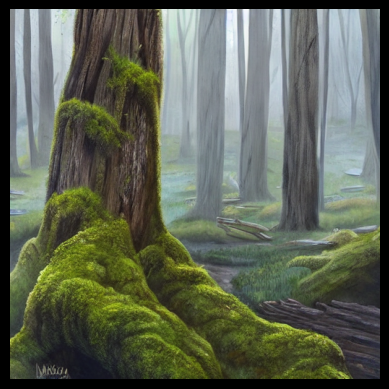

In [ ]:
# Display the image generated

image = generate_image(
    prompt=prompt,
    negative_prompt=negative_prompt,
)

# Show result
if image:
    print("Image generation successful 👍")
    plt.figure(facecolor='black')
    plt.imshow(image)
    plt.axis('off')
    plt.gca().set_facecolor('black')
    plt.show()
else:
    print("failed‼️")